In [1]:
import os
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from haversine import haversine, Unit
from sklearn.metrics.pairwise import haversine_distances
from tqdm import tqdm
from matplotlib.colors import ListedColormap, BoundaryNorm, LogNorm
import pandas as pd
from xhistogram.xarray import histogram
from sklearn.neighbors import KNeighborsRegressor, BallTree
from scipy import stats
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import linregress
import cmocean

def haversine_sklearn(lat1, lon1, lat_array, lon_array):


    X = np.array([lat1, lon1]).reshape(1, -1)
    Y = np.array([lat_array, lon_array]).T
    X = np.radians(X)
    Y = np.radians(Y)

    return haversine_distances(X, Y) * 6357
from matplotlib.colors import BoundaryNorm

colors = np.array([[0.10588235, 0.61960784, 0.46666667, 1.],
                [0.45882353, 0.43921569, 0.70196078, 1.],
                [0.4       , 0.4       , 0.4       , 1.],
                [0.90196078, 0.67058824, 0.00784314, 1.],
])

cmap = ListedColormap(colors)
#cmap = plt.get_cmap('Dark2')
bounds = [1, 2, 3, 4, 5]
norm = BoundaryNorm(bounds, cmap.N)
# Create a figure and axis with the specified size

SIC = xr.open_dataset('/projekt_agmwend/home_rad/Joshua/HALO-AC3_unified_data/amsr_modis_sic.nc').sortby('time')
ds = xr.open_dataset('../../data/ar/HALO-AC3_HALO_VELOX_segmentation_statistics_with_sea_ice_edge_distance.nc')

fontsize = 8

plt.rcParams['font.size'] = fontsize
plt.rcParams['axes.labelsize']  = fontsize
plt.rcParams['axes.titlesize']  = fontsize
plt.rcParams['xtick.labelsize'] = fontsize
plt.rcParams['ytick.labelsize'] = fontsize
plt.rcParams['legend.fontsize'] = fontsize
plt.rcParams['legend.title_fontsize'] = fontsize
plt.rcParams['figure.titlesize'] = fontsize
plt.rcParams['figure.dpi'] = 300
plt.rcParams['axes.axisbelow'] = True
sc_cmap = 'Dark2'


cmap = ListedColormap(colors)



def area_weighted_mean(x, w):
    return np.nansum(x * w) / np.nansum(w)

### calc the area weighted mean of T

awm = area_weighted_mean(ds['segment_T'].values, ds['segment_size'].values)
m = ds['segment_T'].mean().values

print(awm, m)   

ERROR 1: PROJ: proj_create_from_database: Open of /home/jomueller/micromamba/envs/mamba_josh/share/proj failed


-20.916633036886214 -15.185332


total area 24256.238 km²


<>:135: SyntaxWarning: invalid escape sequence '\m'
<>:135: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_237567/2117292062.py:135: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('$T_\mathrm{S}$ (°C)')
/tmp/ipykernel_237567/2117292062.py:55: RuntimeWarning: invalid value encountered in scalar divide
  open_water_mean = np.nansum(open_water_mean * open_water_area) / np.nansum(open_water_area)
/tmp/ipykernel_237567/2117292062.py:55: RuntimeWarning: invalid value encountered in scalar divide
  open_water_mean = np.nansum(open_water_mean * open_water_area) / np.nansum(open_water_area)
/tmp/ipykernel_237567/2117292062.py:55: RuntimeWarning: invalid value encountered in scalar divide
  open_water_mean = np.nansum(open_water_mean * open_water_area) / np.nansum(open_water_area)
/tmp/ipykernel_237567/2117292062.py:55: RuntimeWarning: invalid value encountered in scalar divide
  open_water_mean = np.nansum(open_water_mean * open_water_area) / np.nansum(open_water_area)


0.722441176615995
-3.25 ± 1.55
-11.86 ± 1.13
-16.59 ± 2.04
-22.18 ± 1.41


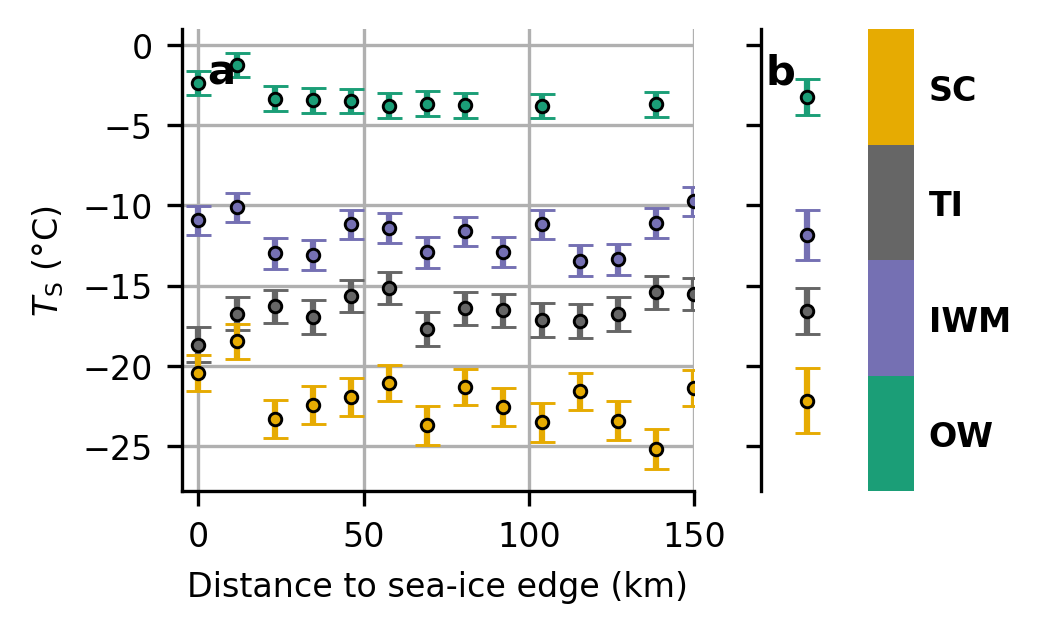

In [2]:
total_area = ds.segment_size.sum()

print('total area', total_area.values/1e4 ,'km²')

spacing = 15

dsgp_edge_dist = ds.groupby_bins('segment_edge_dist', np.linspace(0, 150, spacing))
dsgp_label = ds.groupby('segment_label').sum()

df = pd.DataFrame(
    columns=['Open Water', 'Snow Covered Ice', 'Thin Ice', 'Ice Water Mix'],
    data = np.zeros((spacing-1, 4)),
    #index=np.linspace(0, 200, 20)
)

def error_func(T):
    if T < 100:
        T += 273.15

    e_atm_sca = 0.477
    a_scs = 9.051  # K
    b_scs = 0.967  # K^-1
    e_atm_sca = 0.47  # K
    NETD_B5 = 0.473  # K
    a_b5 = 8.781  # K
    b_b5 = -0.031  # K^-1
    delta_T_B5 = (b_b5 * T + a_b5)
    delta_T_S_sca = np.sqrt(e_atm_sca**2 + b_scs**2 * NETD_B5**2 + (b_scs * delta_T_B5)**2)
    
    return delta_T_S_sca


df_error = pd.DataFrame(
    columns=['Open Water', 'Snow Covered Ice', 'Thin Ice', 'Ice Water Mix'],
    data = np.zeros((spacing-1, 4)),
)


df = df[['Open Water', 'Ice Water Mix', 'Thin Ice', 'Snow Covered Ice']]

#dsgp_edge_dist.segment_size.where(dsgp_edge_dist.segment_label == 2)

for i, group in enumerate(dsgp_edge_dist):
    open_water_mean = group[1].segment_T.where(group[1].segment_label == 1).values
    snow_covered_ice_mean = group[1].segment_T.where(group[1].segment_label == 3).values
    thin_ice_mean = group[1].segment_T.where(group[1].segment_label == 4).values
    ice_water_mix_mean = group[1].segment_T.where(group[1].segment_label == 2).values

    open_water_area = group[1].segment_size.where(group[1].segment_label == 1).values
    snow_covered_ice_area = group[1].segment_size.where(group[1].segment_label == 3).values
    thin_ice_area = group[1].segment_size.where(group[1].segment_label == 4).values
    ice_water_mix_area = group[1].segment_size.where(group[1].segment_label == 2).values


    open_water_mean = np.nansum(open_water_mean * open_water_area) / np.nansum(open_water_area)
    snow_covered_ice_mean = np.nansum(snow_covered_ice_mean * snow_covered_ice_area) / np.nansum(snow_covered_ice_area)
    thin_ice_area = np.nansum(thin_ice_mean * thin_ice_area) / np.nansum(thin_ice_area)
    ice_water_mix_area = np.nansum(ice_water_mix_mean * ice_water_mix_area) / np.nansum(ice_water_mix_area)


    total_area = 1
    df.loc[i, 'Open Water'] = open_water_mean / total_area
    df.loc[i, 'Snow Covered Ice'] = snow_covered_ice_mean / total_area
    df.loc[i, 'Thin Ice'] = thin_ice_area / total_area
    df.loc[i, 'Ice Water Mix'] = ice_water_mix_area / total_area

    df_error.loc[i, 'Open Water'] = error_func(open_water_mean)
    df_error.loc[i, 'Snow Covered Ice'] = error_func(snow_covered_ice_mean)
    df_error.loc[i, 'Thin Ice'] = error_func(thin_ice_area)
    df_error.loc[i, 'Ice Water Mix'] = error_func(ice_water_mix_area)

df.set_index(np.linspace(0, 150, spacing-1), inplace=True)
df_error.set_index(np.linspace(0, 150, spacing-1), inplace=True)

fig, (ax, ax2) = plt.subplots(1, 2, figsize=(3.15, 2),
                               gridspec_kw={'width_ratios': [1, .3]},
                               sharey=True)

#im = df.plot(stacked=False, cmap=cmap, ax=ax, alpha=.8, legend=False, linewidth=0, label='')
im = df.plot(cmap=cmap, alpha=.8, legend=False, label='', marker='o', ax=ax, markersize=2, linewidth=0)

#ax.legend(title='Surface type', loc='upper right', fontsize=6)
### add a colorbar instead of a legend

### make a colormap from listedcolors 

# from matplotlib.colors import ListedColormap

# cmap = ListedColormap(colors)

means = df.mean()
means_label = [1, 2, 3, 4]

#ax2.scatter([0,0,0,0], means, c=means_label, cmap=cmap, edgecolors='k', lw=.5, s=50)
ax2.set_xticks([])
ax2.spines[['top', 'right', 'bottom']].set_visible(False)

im = ax.contourf(np.array([[1, 2, 3, 4], [1, 2, 0, 4]]), cmap=cmap, alpha=1, levels=[0.5, 1.5, 2.5, 3.5, 4.5])
im.set_visible(False)

from mpl_toolkits.axes_grid1 import make_axes_locatable

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='50%', pad=0.05)

cbar = fig.colorbar(im, cax=cax, orientation='vertical', ticks=[1, 2, 3, 4])
cbar.set_ticklabels(['Open\nWater', 'Ice Water\nMix', 'Thin\nIce', 'Snow Covered\nIce'])
cbar.set_ticklabels(['OW', 'IWM', 'TI', 'SC'], fontweight='bold')
cbar.ax.yaxis.set_tick_params(width=0, length=0)
cbar.ax.yaxis.set_ticks_position('none')
cbar.ax.set_frame_on(False)

colors = np.array([[0.10588235, 0.61960784, 0.46666667, 1.],
                [0.45882353, 0.43921569, 0.70196078, 1.],
                [0.4       , 0.4       , 0.4       , 1.],
                [0.90196078, 0.67058824, 0.00784314, 1.],
])

print(error_func(273.15))   

ax.axes.grid(True)
# imi = (1 - ds.groupby_bins('segment_edge_dist', np.linspace(0, 150, 50)).mean().segment_sic / 100).plot(ax=ax, color='r', linestyle='--', linewidth=1, zorder=100)

# label = ['MODIS/AMSR 1-SIC']
# handles = imi

# ax.legend(handles, label, loc='upper right', fontsize=8)

ax.spines[['top', 'right']].set_visible(False)
ax.set_xlabel('distance (km)')
# ax.text(-0.1, -0.35, '    Ice edge\n   (SIC = 10%)\n  ← Open Ocean', transform=ax.transAxes, fontweight='bold', fontsize=8)
# #ax.text(-0.27, -0.2, '← Open Ocean\n', transform=ax.transAxes, fontweight='bold', fontsize=6)
# #ax.text(0.8, -0.2, '→\n', transform=ax.transAxes, fontweight='bold', fontsize=6)
# ax.text(.9, -0.35 , 'Internal  →\nice zone \n', transform=ax.transAxes, fontweight='bold', fontsize=8)
ax.set_ylabel('$T_\mathrm{S}$ (°C)')
ax.axes.grid(True)
#ax.set_xlim([0, 150])
# ax.set_ylim([0, 1])
ax.set_xlabel('Distance to sea-ice edge (km)')


ax.text(0.05, 0.95, 'a', transform=ax.transAxes, fontsize=10, fontweight='bold', va='top')
ax2.text(0.05, 0.95, 'b', transform=ax2.transAxes, fontsize=10, fontweight='bold', va='top')


#### fill a sheded area with the error + - the mean 

total_error  = (df.std()**2 + df_error.mean()**2)**.5

for i, col in enumerate(df.columns):
    #ax.fill_between(df.index, df.loc[:, col] - df_error.loc[:, col], df.loc[:, col] + df_error.loc[:, col], alpha=.4, color=colors[i])

    ax.errorbar(df.index, df.loc[:, col], yerr=df_error.loc[:, col], fmt='o', color=colors[i], markersize=3, label=col, capsize=3, capthick=2, markeredgecolor='black', markeredgewidth=.7)
    ax2.errorbar([0], means[col], yerr=total_error[col], fmt='o', color=colors[i], markersize=3, label='Total error', capsize=3, capthick=2, markeredgecolor='black', markeredgewidth=.7)


ax.set_xlim([-5, 150])




plt.savefig('../../plots/publish/figure09.png', bbox_inches='tight', dpi=300)



for m, e in zip(means, total_error):
    print(f'{m:.2f} ± {e:.2f}')
